<a href="https://colab.research.google.com/github/Nisha40108/ParkNaviGo/blob/main/Class_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 114.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 51.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.

### <b>Importing All the libraries</b>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import zipfile
import io
import os
import shutil
import pathlib
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from io import BytesIO
from zipfile import ZipFile

In [ ]:
#import shutil
#import os

#zip_file_path = '/content/sample_data/Train_data'
#extracted_folder_path = '/content/sample_data/KSU_Parking_data'

# Unzip the file
#shutil.unpack_archive(zip_file_path, extracted_folder_path, 'zip')

In [15]:
import os
import shutil
import pathlib
import random

original_dir = pathlib.Path("/content/sample_data/Train_Data_2")
new_base_dir = pathlib.Path("/content/sample_data/KSU_Parking_data")

def make_subset(subset_name, start_index, end_index):
    indices = list(range(start_index + 1, min(end_index + 1, 300)))
    random.shuffle(indices)  # Shuffle the indices randomly

    for category in ("empty", "occupied"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        fnames = [f"{category} {i}.png" for i in indices]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# 70% for training
make_subset("train_data", start_index=0, end_index=210)

# 15% for validation
make_subset("validation_data", start_index=211, end_index=256)

# 15% for testing
make_subset("test_data", start_index=257, end_index=305)



### <b>Importing the Empty and Non empty dataset </b>

### <b>Creating Train, validation and Test dataset in </b>

In [16]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train_data",
    image_size=(224, 224),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_data",
    image_size=(224, 224),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_data",
    image_size=(224, 224),
    batch_size=32)

Found 420 files belonging to 2 classes.
Found 90 files belonging to 2 classes.
Found 84 files belonging to 2 classes.


### <b>Checking for the shape and label for image </b>

In [17]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


### <b>Display the first 9 images </b>

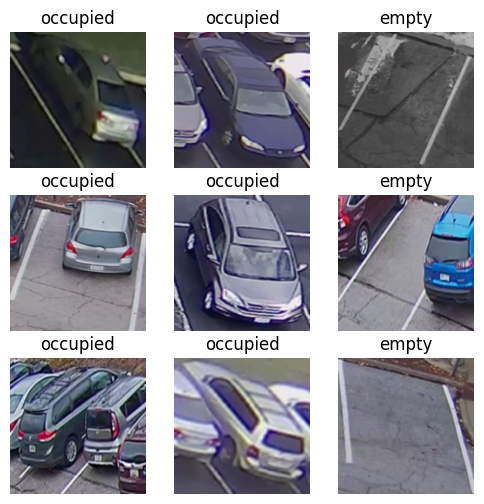

In [18]:
class_names = train_dataset.class_names

plt.figure(figsize=(6, 6))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# **Model - 1 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers**

In [19]:
#Building the model
#Instantiating a small convnet for dogs vs. cats classification
#**

inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                         

### **Training The model**

In [21]:
# Compilimg the results of the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


# Saving the results of the model
callbacks = ModelCheckpoint(
            filepath= "model1.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting/Running the Model
Model_1 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/50
14/14 [==============================] - 13s 126ms/step - loss: 0.6947 - accuracy: 0.4786 - val_loss: 0.6247 - val_accuracy: 0.5889
Epoch 2/50
14/14 [==============================] - 1s 55ms/step - loss: 0.4819 - accuracy: 0.7881 - val_loss: 2.9474 - val_accuracy: 0.5333
Epoch 3/50
14/14 [==============================] - 1s 58ms/step - loss: 0.5656 - accuracy: 0.7857 - val_loss: 0.5038 - val_accuracy: 0.8333
Epoch 4/50
14/14 [==============================] - 1s 57ms/step - loss: 0.2372 - accuracy: 0.9119 - val_loss: 0.4186 - val_accuracy: 0.8889
Epoch 5/50
14/14 [==============================] - 1s 58ms/step - loss: 0.1420 - accuracy: 0.9357 - val_loss: 0.2455 - val_accuracy: 0.8889
Epoch 6/50
14/14 [==============================] - 1s 57ms/step - loss: 0.1096 - accuracy: 0.9571 - val_loss: 0.2425 - val_accuracy: 0.9222
Epoch 7/50
14/14 [==============================] - 1s 58ms/step - loss: 0.0875 - accuracy: 0.9667 - val_loss: 0.2323 - val_accuracy: 0.8889
Epoch 8/50


### **Looking at the visuals of the Training and Validation Accuracy/Loss**

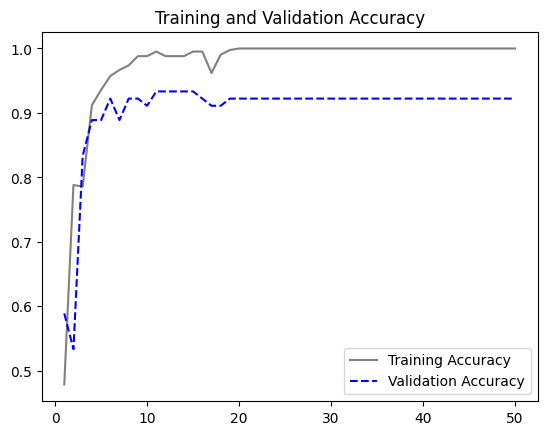

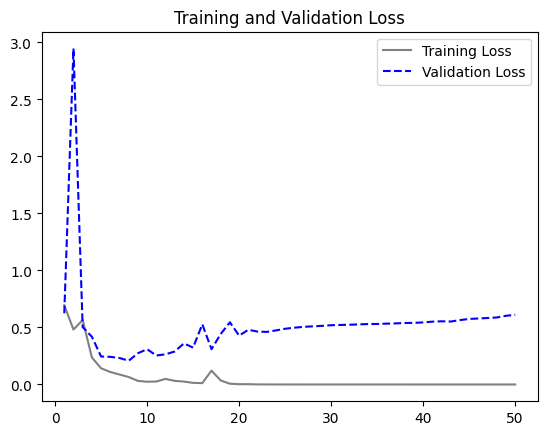

In [22]:
accuracy = Model_1.history["accuracy"]
val_accuracy = Model_1.history["val_accuracy"]

loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_1 on test set**

In [23]:
test_model = keras.models.load_model("model1.keras")
Model1_Results = test_model.evaluate(test_dataset)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

3/3 [==============================] - 1s 147ms/step - loss: 0.2573 - accuracy: 0.9048
Loss: 0.257
Accuracy: 0.905


### **Using Measures to Avoid Overfitting - Using Data Auguentation**

In [24]:
# To deprecate warnings that are making the output look clumsy
import logging
logging.getLogger('tensorflow').disabled = True

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
        layers.RandomRotation(factor=0.05),
    ]
)

### **Looking at the augmented images**

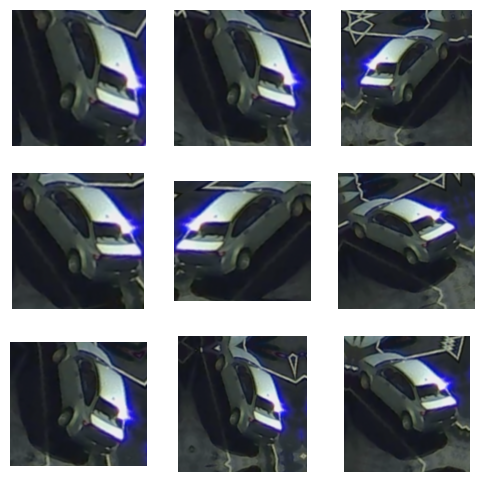

In [26]:
plt.figure(figsize=(6, 6))
for images, _ in train_dataset.take(1):
   for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

# **Model-2 MaxPooling Operation with Increase in filters from 32 to 512 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.5**

In [27]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                       

### **Training The model**

In [28]:
# Compiling the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model
callbacks = ModelCheckpoint(
            filepath= "model2.keras",
            save_best_only= True,
            monitor= "val_loss")

# Fitting/Running the Model
Model_2 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/50
14/14 [==============================] - 3s 74ms/step - loss: 0.6631 - accuracy: 0.5381 - val_loss: 0.8257 - val_accuracy: 0.5111
Epoch 2/50
14/14 [==============================] - 1s 58ms/step - loss: 0.4426 - accuracy: 0.7881 - val_loss: 0.5187 - val_accuracy: 0.7444
Epoch 3/50
14/14 [==============================] - 1s 54ms/step - loss: 0.2453 - accuracy: 0.9167 - val_loss: 0.7466 - val_accuracy: 0.7778
Epoch 4/50
14/14 [==============================] - 1s 58ms/step - loss: 0.1773 - accuracy: 0.9381 - val_loss: 0.4863 - val_accuracy: 0.9000
Epoch 5/50
14/14 [==============================] - 1s 58ms/step - loss: 0.2622 - accuracy: 0.9024 - val_loss: 0.3889 - val_accuracy: 0.8556
Epoch 6/50
14/14 [==============================] - 1s 57ms/step - loss: 0.1820 - accuracy: 0.9381 - val_loss: 0.3096 - val_accuracy: 0.8778
Epoch 7/50
14/14 [==============================] - 1s 58ms/step - loss: 0.1388 - accuracy: 0.9452 - val_loss: 0.3052 - val_accuracy: 0.8889
Epoch 8/50
14

### **Looking at the visuals of the Training and Validation Accuracy/Loss**

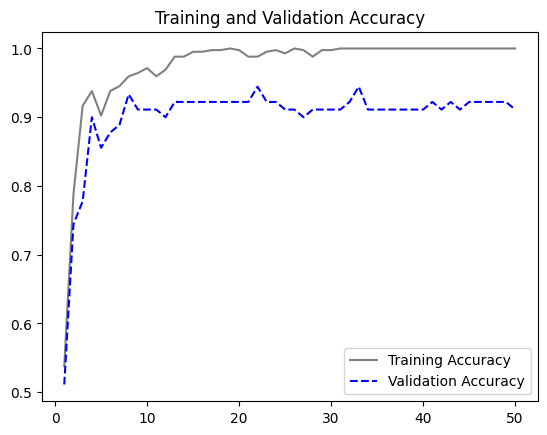

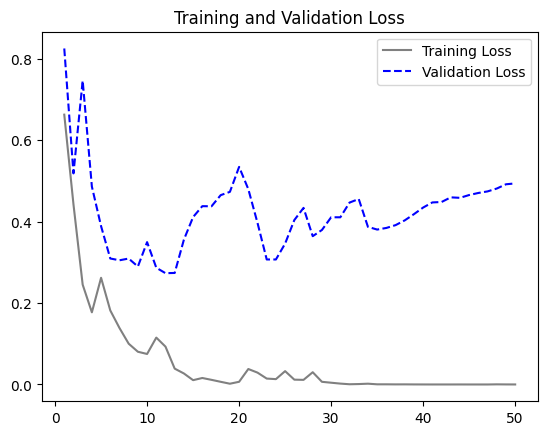

In [29]:
accuracy = Model_2.history["accuracy"]
val_accuracy = Model_2.history["val_accuracy"]

loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_2 on the test set**

In [30]:
test_model = keras.models.load_model("model2.keras")
Model2_Results = test_model.evaluate(test_dataset)
print(f'Loss: {Model2_Results[0]:.3f}')
print(f'Accuracy: {Model2_Results[1]:.3f}')

3/3 [==============================] - 0s 16ms/step - loss: 0.2228 - accuracy: 0.9167
Loss: 0.223
Accuracy: 0.917


# **Model - 3 MaxPooling Operation with Increase in filters from 32 to 512 in 6 Input Layers with the use of Augmented Images and Dropout rate of 0.2**

In [31]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                       

### **Training the model 3**

In [32]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ["accuracy"])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath= "model3.keras",
            save_best_only= True,
            monitor= "val_loss")


# Model Fit
Model_3 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/50
14/14 [==============================] - 4s 105ms/step - loss: 0.5800 - accuracy: 0.6690 - val_loss: 0.3967 - val_accuracy: 0.8667
Epoch 2/50
14/14 [==============================] - 1s 57ms/step - loss: 0.4519 - accuracy: 0.8357 - val_loss: 0.4104 - val_accuracy: 0.8556
Epoch 3/50
14/14 [==============================] - 1s 63ms/step - loss: 0.2613 - accuracy: 0.8905 - val_loss: 0.3045 - val_accuracy: 0.9000
Epoch 4/50
14/14 [==============================] - 1s 63ms/step - loss: 0.1995 - accuracy: 0.9357 - val_loss: 0.2096 - val_accuracy: 0.9222
Epoch 5/50
14/14 [==============================] - 1s 58ms/step - loss: 0.1359 - accuracy: 0.9381 - val_loss: 0.2927 - val_accuracy: 0.9000
Epoch 6/50
14/14 [==============================] - 1s 58ms/step - loss: 0.1058 - accuracy: 0.9619 - val_loss: 0.2150 - val_accuracy: 0.9333
Epoch 7/50
14/14 [==============================] - 1s 63ms/step - loss: 0.1013 - accuracy: 0.9595 - val_loss: 0.1947 - val_accuracy: 0.9222
Epoch 8/50
1

### **Visualizing the Training and Validation Accuracy/Loss 2**

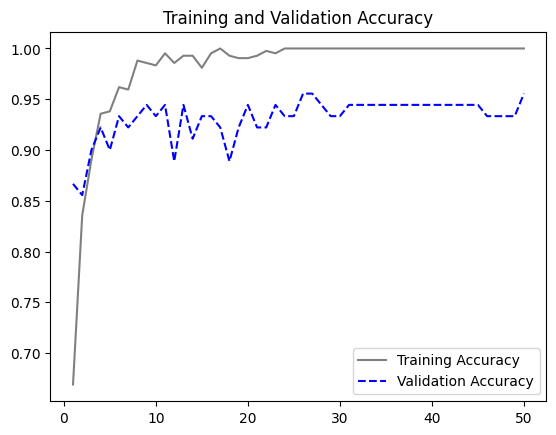

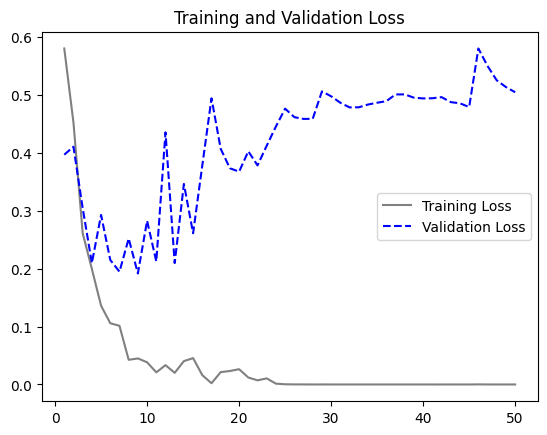

In [33]:
accuracy = Model_3.history["accuracy"]
val_accuracy = Model_3.history["val_accuracy"]

loss = Model_3.history["loss"]
val_loss = Model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_2 on the test set**

In [34]:
best_model = keras.models.load_model("model3.keras")
Model3_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model3_Results[0]:.3f}')
print(f'Accuracy: {Model3_Results[1]:.3f}')

3/3 [==============================] - 0s 32ms/step - loss: 0.3816 - accuracy: 0.8929
Loss: 0.382
Accuracy: 0.893


# **Model - 4 MaxPooling Operation with Increase in filters from 64 to 1024 in 5 Input Layers with the use of Augmented Images and Dropout rate of 0.2**

In [35]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                      

### **Training The model**

In [36]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model4.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_4 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
14/14 [==============================] - 5s 115ms/step - loss: 0.5964 - accuracy: 0.6857 - val_loss: 0.3984 - val_accuracy: 0.8778
Epoch 2/50
14/14 [==============================] - 1s 66ms/step - loss: 0.3413 - accuracy: 0.8571 - val_loss: 0.4396 - val_accuracy: 0.8889
Epoch 3/50
14/14 [==============================] - 1s 79ms/step - loss: 0.3475 - accuracy: 0.8929 - val_loss: 0.3213 - val_accuracy: 0.8444
Epoch 4/50
14/14 [==============================] - 1s 65ms/step - loss: 0.2421 - accuracy: 0.8952 - val_loss: 0.3860 - val_accuracy: 0.8667
Epoch 5/50
14/14 [==============================] - 1s 66ms/step - loss: 0.1271 - accuracy: 0.9452 - val_loss: 0.4190 - val_accuracy: 0.8778
Epoch 6/50
14/14 [==============================] - 1s 79ms/step - loss: 0.2129 - accuracy: 0.9119 - val_loss: 0.3009 - val_accuracy: 0.8889
Epoch 7/50
14/14 [==============================] - 1s 65ms/step - loss: 0.1183 - accuracy: 0.9619 - val_loss: 0.3317 - val_accuracy: 0.9000
Epoch 8/50
1

### **Visualizing the Training and Validation Accuracy/Loss 2**

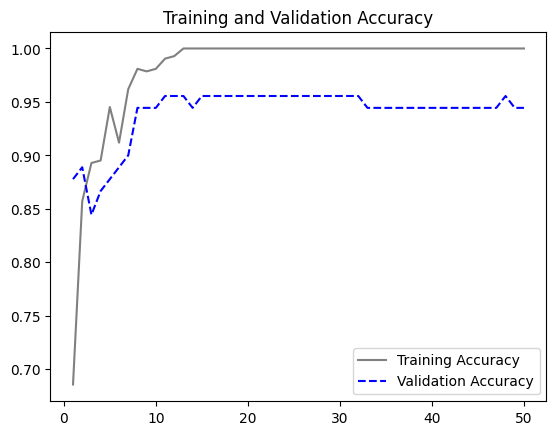

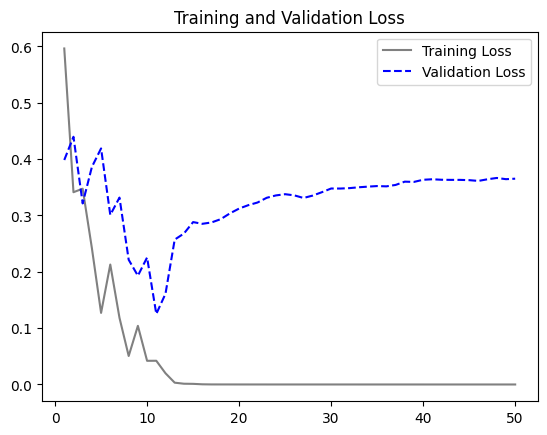

In [37]:
accuracy = Model_4.history["accuracy"]
val_accuracy = Model_4.history["val_accuracy"]

loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_4 on the test set**

In [38]:
best_model = keras.models.load_model("model4.keras")
Model4_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model4_Results[0]:.3f}')
print(f'Accuracy: {Model4_Results[1]:.3f}')

3/3 [==============================] - 0s 118ms/step - loss: 0.2421 - accuracy: 0.9524
Loss: 0.242
Accuracy: 0.952


# **Model - 5 MaxPooling Operation with Increase in filters from 64 to 1024 in 5 Input Layers with the use of Augmented Images and Dropout rate of 0.6**

In [39]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                      

### **Training The model**

In [40]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model5.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_5 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
14/14 [==============================] - 4s 88ms/step - loss: 0.6299 - accuracy: 0.6262 - val_loss: 0.4273 - val_accuracy: 0.8333
Epoch 2/50
14/14 [==============================] - 1s 78ms/step - loss: 0.3774 - accuracy: 0.8762 - val_loss: 0.4121 - val_accuracy: 0.8556
Epoch 3/50
14/14 [==============================] - 1s 65ms/step - loss: 0.2338 - accuracy: 0.9095 - val_loss: 0.4335 - val_accuracy: 0.9000
Epoch 4/50
14/14 [==============================] - 1s 65ms/step - loss: 0.1986 - accuracy: 0.9286 - val_loss: 0.4214 - val_accuracy: 0.8778
Epoch 5/50
14/14 [==============================] - 1s 77ms/step - loss: 0.2187 - accuracy: 0.9119 - val_loss: 0.2318 - val_accuracy: 0.9222
Epoch 6/50
14/14 [==============================] - 1s 80ms/step - loss: 0.1605 - accuracy: 0.9452 - val_loss: 0.1253 - val_accuracy: 0.9333
Epoch 7/50
14/14 [==============================] - 1s 66ms/step - loss: 0.1405 - accuracy: 0.9500 - val_loss: 0.3114 - val_accuracy: 0.9000
Epoch 8/50
14

### **Visualizing the Training and Validation Accuracy/Loss 2**

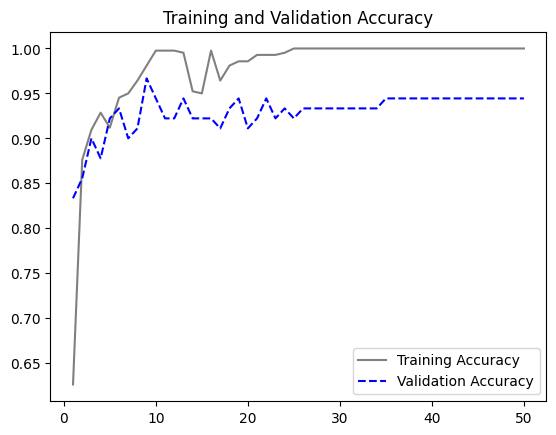

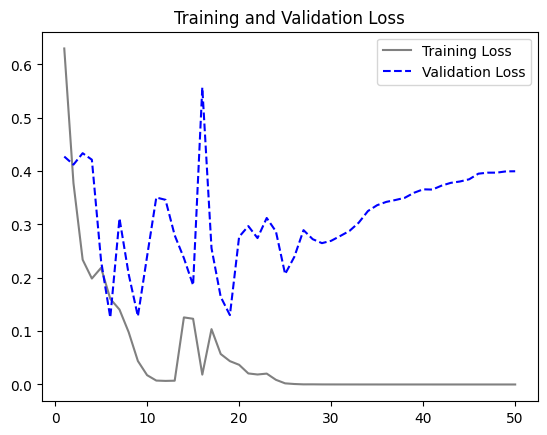

In [41]:
accuracy = Model_5.history["accuracy"]
val_accuracy = Model_5.history["val_accuracy"]

loss = Model_5.history["loss"]
val_loss = Model_5.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_5 on the test set**

In [42]:
test_model = keras.models.load_model("model5.keras")
Model5_Results = test_model.evaluate(test_dataset)
print(f'Loss: {Model5_Results[0]:.3f}')
print(f'Accuracy: {Model5_Results[1]:.3f}')

3/3 [==============================] - 0s 18ms/step - loss: 0.2973 - accuracy: 0.8810
Loss: 0.297
Accuracy: 0.881


### **Agumenting the data again**

In [43]:
data_augmentation_2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)

# **Model -6 : 5 hidden layer, Stride = 2, Padding = same and Dropout 0.5**

In [44]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2, padding="same")(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 109, 109, 64)      18496     
                                                           

In [45]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model6.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_6 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
14/14 [==============================] - 5s 110ms/step - loss: 0.7047 - accuracy: 0.5119 - val_loss: 0.6885 - val_accuracy: 0.5333
Epoch 2/50
14/14 [==============================] - 1s 68ms/step - loss: 0.6757 - accuracy: 0.6000 - val_loss: 0.6265 - val_accuracy: 0.7667
Epoch 3/50
14/14 [==============================] - 1s 68ms/step - loss: 0.5062 - accuracy: 0.7881 - val_loss: 0.4171 - val_accuracy: 0.8222
Epoch 4/50
14/14 [==============================] - 1s 63ms/step - loss: 0.3984 - accuracy: 0.8429 - val_loss: 0.4255 - val_accuracy: 0.8111
Epoch 5/50
14/14 [==============================] - 1s 62ms/step - loss: 0.3729 - accuracy: 0.8476 - val_loss: 0.5482 - val_accuracy: 0.7889
Epoch 6/50
14/14 [==============================] - 1s 63ms/step - loss: 0.3037 - accuracy: 0.8881 - val_loss: 0.6039 - val_accuracy: 0.7889
Epoch 7/50
14/14 [==============================] - 1s 64ms/step - loss: 0.3089 - accuracy: 0.8643 - val_loss: 0.5126 - val_accuracy: 0.8000
Epoch 8/50
1

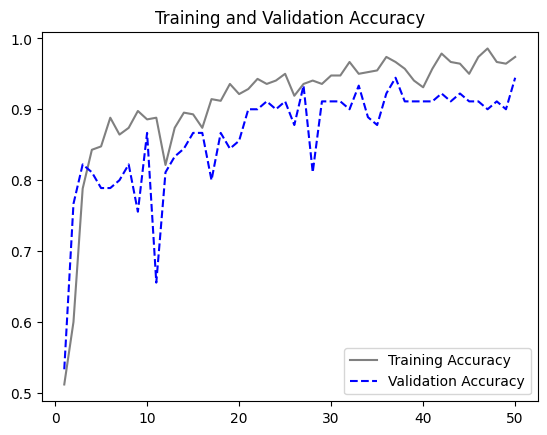

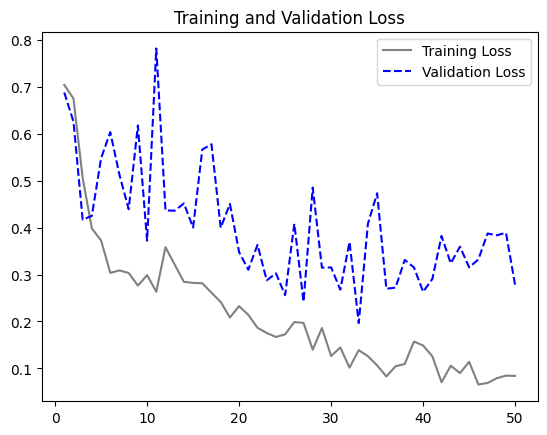

In [46]:
accuracy = Model_6.history["accuracy"]
val_accuracy = Model_6.history["val_accuracy"]

loss = Model_6.history["loss"]
val_loss = Model_6.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [47]:
best_model = keras.models.load_model("model6.keras")
Model6_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model6_Results[0]:.3f}')
print(f'Accuracy: {Model6_Results[1]:.3f}')

3/3 [==============================] - 0s 97ms/step - loss: 0.2438 - accuracy: 0.9048
Loss: 0.244
Accuracy: 0.905


In [48]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [49]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model7.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_7 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
14/14 [==============================] - 4s 79ms/step - loss: 0.6893 - accuracy: 0.5286 - val_loss: 0.6185 - val_accuracy: 0.6889
Epoch 2/50
14/14 [==============================] - 1s 64ms/step - loss: 0.5069 - accuracy: 0.7833 - val_loss: 0.4485 - val_accuracy: 0.8222
Epoch 3/50
14/14 [==============================] - 1s 59ms/step - loss: 0.4818 - accuracy: 0.8095 - val_loss: 0.4738 - val_accuracy: 0.8333
Epoch 4/50
14/14 [==============================] - 1s 64ms/step - loss: 0.4184 - accuracy: 0.8619 - val_loss: 0.4389 - val_accuracy: 0.8556
Epoch 5/50
14/14 [==============================] - 1s 64ms/step - loss: 0.3643 - accuracy: 0.8595 - val_loss: 0.4369 - val_accuracy: 0.8667
Epoch 6/50
14/14 [==============================] - 1s 59ms/step - loss: 0.2827 - accuracy: 0.9048 - val_loss: 0.6155 - val_accuracy: 0.7556
Epoch 7/50
14/14 [==============================] - 1s 59ms/step - loss: 0.2908 - accuracy: 0.8667 - val_loss: 0.5027 - val_accuracy: 0.8333
Epoch 8/50
14

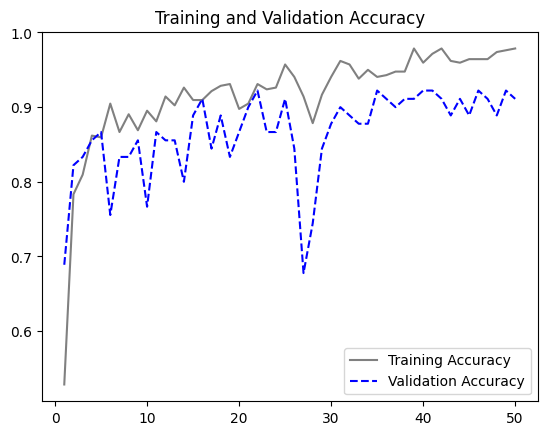

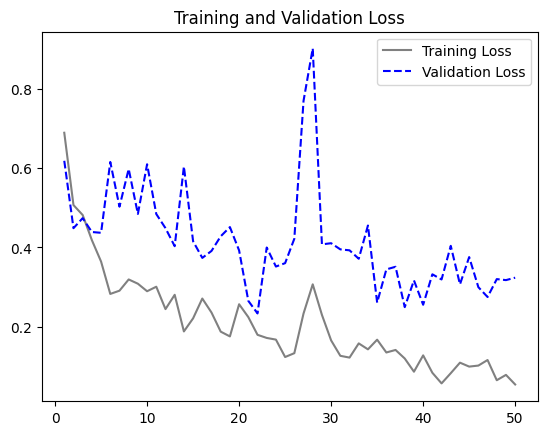

In [50]:
accuracy = Model_7.history["accuracy"]
val_accuracy = Model_7.history["val_accuracy"]

loss = Model_7.history["loss"]
val_loss = Model_7.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [51]:
best_model = keras.models.load_model("model7.keras")
Model7_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model7_Results[0]:.3f}')
print(f'Accuracy: {Model7_Results[1]:.3f}')

3/3 [==============================] - 0s 17ms/step - loss: 0.1985 - accuracy: 0.9405
Loss: 0.199
Accuracy: 0.940


# **Pre Trained Model: Build a model on top of VGG16**

In [52]:
import numpy
import os
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

### **Pre trained VGG16 model**

In [53]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 3s 0us/step


### **Summary of Pre Trained Model**

In [54]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### **extracting VGG 16 features and Labels**

In [55]:

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 3s 3s/step


In [56]:
train_features.shape

(420, 7, 7, 512)

In [57]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

### **Before Freezing**

In [58]:

conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


### **After Freezing**

In [59]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [60]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **VGG - Model 7 Dense Layer with 256 Nodes and Droput Rate of 0.5 and optimizer being rmsprop with the Augmented Images**

In [61]:
# Data Augmentation -Adding a data augmentation stage to provide augmented training samples and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

In [62]:
# Compiling the Model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Using CallBacks to monitor the best val_loss
callbacks = ModelCheckpoint(
            filepath= "vgg_model2.keras",
            save_best_only= True,
            monitor= "val_loss")

# Model Fit
VGG_Model_2 = model.fit(
              train_dataset,
              epochs= 50,
              validation_data=validation_dataset,
              callbacks=callbacks)

Epoch 1/50
14/14 [==============================] - 5s 191ms/step - loss: 47.2664 - accuracy: 0.8452 - val_loss: 7.6323 - val_accuracy: 0.9444
Epoch 2/50
14/14 [==============================] - 3s 181ms/step - loss: 5.2104 - accuracy: 0.9548 - val_loss: 4.0753 - val_accuracy: 0.9333
Epoch 3/50
14/14 [==============================] - 3s 181ms/step - loss: 9.3568 - accuracy: 0.9357 - val_loss: 0.4535 - val_accuracy: 0.9778
Epoch 4/50
14/14 [==============================] - 2s 164ms/step - loss: 1.0753 - accuracy: 0.9905 - val_loss: 0.9246 - val_accuracy: 0.9667
Epoch 5/50
14/14 [==============================] - 2s 166ms/step - loss: 1.9327 - accuracy: 0.9881 - val_loss: 5.6177 - val_accuracy: 0.9556
Epoch 6/50
14/14 [==============================] - 2s 167ms/step - loss: 1.5448 - accuracy: 0.9857 - val_loss: 3.3648 - val_accuracy: 0.9667
Epoch 7/50
14/14 [==============================] - 2s 167ms/step - loss: 2.5503 - accuracy: 0.9833 - val_loss: 0.8971 - val_accuracy: 0.9778
Epoch

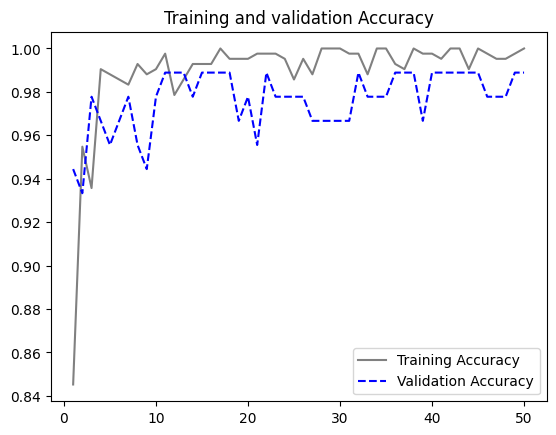

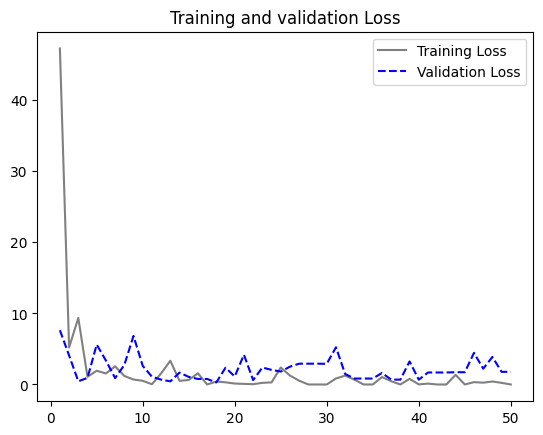

In [63]:
acc = VGG_Model_2.history["accuracy"]
val_acc = VGG_Model_2.history["val_accuracy"]

loss = VGG_Model_2.history["loss"]
val_loss = VGG_Model_2.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [64]:
best_model = keras.models.load_model("vgg_model2.keras")
VGG_Model_2_Results= best_model.evaluate(test_dataset)
print(f'Loss: {VGG_Model_2_Results[0]:.3f}')
print(f'Accuracy: {VGG_Model_2_Results[1]:.3f}')

3/3 [==============================] - 1s 130ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Loss: 0.000
Accuracy: 1.000


# **Model 8 : Fine Tunning VGG_Mode**

In [65]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### **Training the model**

In [66]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])


callbacks = ModelCheckpoint(
            filepath="fine_tuning_vgg_model2.keras",
            save_best_only=True,
            monitor="val_loss")


FineTuned_VGG_Model_2 = model.fit(
                        train_dataset,
                        epochs=30,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/30
14/14 [==============================] - 6s 230ms/step - loss: 0.0358 - accuracy: 0.9976 - val_loss: 2.7420 - val_accuracy: 0.9778
Epoch 2/30
14/14 [==============================] - 3s 211ms/step - loss: 9.3532e-04 - accuracy: 1.0000 - val_loss: 1.3879 - val_accuracy: 0.9889
Epoch 3/30
14/14 [==============================] - 3s 192ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.3879 - val_accuracy: 0.9889
Epoch 4/30
14/14 [==============================] - 3s 192ms/step - loss: 2.0301e-30 - accuracy: 1.0000 - val_loss: 1.3879 - val_accuracy: 0.9889
Epoch 5/30
14/14 [==============================] - 3s 193ms/step - loss: 0.4146 - accuracy: 0.9952 - val_loss: 1.9022 - val_accuracy: 0.9889
Epoch 6/30
14/14 [==============================] - 3s 194ms/step - loss: 2.6427e-11 - accuracy: 1.0000 - val_loss: 1.9022 - val_accuracy: 0.9889
Epoch 7/30
14/14 [==============================] - 3s 193ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.9022 - val_acc

### **Visualizing the Training and Validation Accuracy/Loss 8**

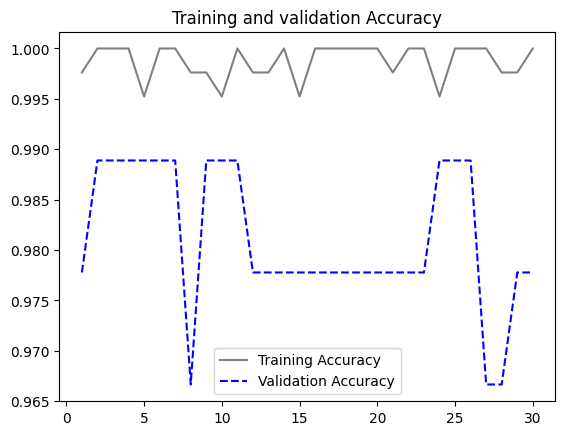

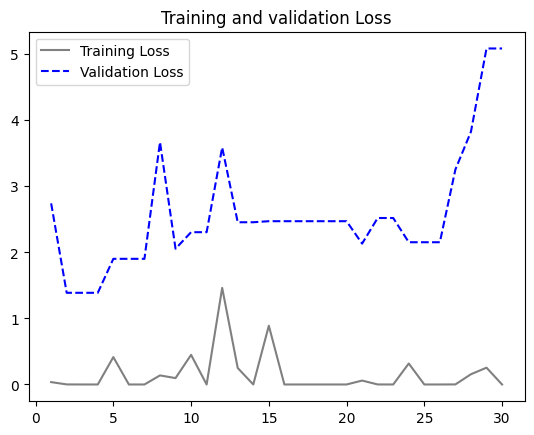

In [67]:
acc = FineTuned_VGG_Model_2.history["accuracy"]
val_acc = FineTuned_VGG_Model_2.history["val_accuracy"]

loss = FineTuned_VGG_Model_2.history["loss"]
val_loss = FineTuned_VGG_Model_2.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_8 on test set**

In [68]:
best_model = keras.models.load_model("fine_tuning_vgg_model2.keras")
FineTuned_VGG_Model_2_Results = best_model.evaluate(test_dataset)
print(f"Loss: {FineTuned_VGG_Model_2_Results[0]:.3f}")
print(f"Accuracy: {FineTuned_VGG_Model_2_Results[1]:.3f}")

3/3 [==============================] - 1s 134ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Loss: 0.000
Accuracy: 1.000
